## 一、背景
大学排名是一个非常重要同时也极富挑战性与争议性的问题，一所大学的综合实力涉及科研、师资、学生等方方面面。目前全球有上百家评估机构会评估大学的综合得分进行排序，而这些机构的打分也往往并不一致。在这些评分机构中，世界大学排名中心（Center for World University Rankings，缩写CWUR）以评估教育质量、校友就业、研究成果和引用，而非依赖于调查和大学所提交的数据著称，是非常有影响力的一个。

本数据来自 Kaggle 的[数据](https://www.kaggle.com/mylesoneill/world-university-rankings?select=cwurData.csv)，构建「线性回归」模型，根据大学各项指标的排名预测综合得分。


## 二、任务

本任务中我们将根据 CWUR 所提供的世界各地知名大学各方面的排名（师资、科研等），一方面通过数据可视化的方式观察不同大学的特点，另一方面希望构建机器学习模型（线性回归）预测一所大学的综合得分。

## 三、评价指标
**基本要求：**
* 按照 8:2 随机划分训练集测试集，用 RMSE 作为评价指标，得到测试集上线性回归模型的 RMSE 值；
* 对线性回归模型的系数进行分析。

**扩展要求：**
* 对数据进行观察与可视化，展示数据特点；
* 尝试其他的回归模型，对比效果；
* 尝试将离散的地区特征融入线性回归模型，并对结果进行对比。

## 四、模型训练

### 4.1 导入工具包

In [27]:
import pandas as pd                                                     # 数据处理
from ydata_profiling import ProfileReport                               # 自动化特征分析和生成报告
import numpy as np                                                      # 数学运算
from sklearn.model_selection import train_test_split, cross_validate    # 划分数据集函数
from sklearn.linear_model import LinearRegression                       # 线性回归
from sklearn.metrics import mean_squared_error, r2_score                # 准确率函数
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt                                         # 绘制图形，如散点图、柱状图、饼图
import seaborn as sns                                                   # 热力图
from sklearn.preprocessing import OneHotEncoder                         # 独热编码
import torch
import torch.utils.data as Data
RANDOM_SEED = 128 # 固定随机种子

### 4.2 读入数据
假设数据文件位于当前文件夹下的data，用 pandas 读入标准 csv 格式文件的函数`read_csv()`将数据转换为`DataFrame`的形式。观察前几条数据记录：

In [28]:
data_df = pd.read_csv('./data/cwurData.csv')                            # 读入 csv 文件为 pandas 的 DataFrame
print(data_df.iloc[0])                                                  # 输出第一行数据
data_df.describe()                                                      # 每列特征的简单统计信息

world_rank                               1
institution             Harvard University
region                                 USA
national_rank                            1
quality_of_education                     7
alumni_employment                        9
quality_of_faculty                       1
publications                             1
influence                                1
citations                                1
broad_impact                           NaN
patents                                  5
score                                100.0
year                                  2012
Name: 0, dtype: object


,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2000.000000,2200.000000,2200.000000,2200.000000
mean,459.590909,40.278182,275.100455,357.116818,178.888182,459.908636,459.797727,413.417273,496.699500,433.346364,47.798395,2014.318182
std,304.320363,51.740870,121.935100,186.779252,64.050885,303.760352,303.331822,264.366549,286.919755,273.996525,7.760806,0.762130
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,43.360000,2012.000000
25%,175.750000,6.000000,175.750000,175.750000,175.750000,175.750000,175.750000,161.000000,250.500000,170.750000,44.460000,2014.000000
50%,450.500000,21.000000,355.000000,450.500000,210.000000,450.500000,450.500000,406.000000,496.000000,426.000000,45.100000,2014.000000
75%,725.250000,49.000000,367.000000,478.000000,218.000000,725.000000,725.250000,645.000000,741.000000,714.250000,47.545000,2015.000000
max,1000.000000,229.000000,367.000000,567.000000,218.000000,1000.000000,991.000000,812.000000,1000.000000,871.000000,100.000000,2015.000000


### 4.3 特征工程

#### 4.3.1 特征概览

基本输入特征有 8 个：`quality_of_education`, `alumni_employment`, `quality_of_faculty`, `publications`, `influence`, `citations`, `broad_impact`, `patents`；预测目标为`score`.如下表所示：
<div style="text-align:center">

| 序号 | 特征 | 备注 |
|----------|----------|----------|
| 1 | world_rank               | 序号 |
| 2 | institution              | 校名 |
| 3 | region                   | 国籍 |
| 4 | national_rank            | 国内排名 |
| 5 | quality_of_education     | 教育质量 |
| 6 | alumni_employment        | 校友就业 |
| 7 | quality_of_faculty       | 师资力量 |
| 8 | publications             | 论文发表
| 9 | influence                | 影响力 |
| 10 | citations               | 论文引用 |
| 11 | broad_impact            | 广泛影响力 |
| 12 | patents                 | 专利 |
| 13 | year                    | 年度 |
| 14 | score                   | 得分 |

</div>

自动化特征分析报告

In [29]:
# 创建报告
profile = ProfileReport(data_df, title='Pandas Profiling Report', explorative=True)

# 在Notebook中嵌入报告
# profile.to_notebook_iframe()
# 将报告保存为HTML文件
profile.to_file('./data/data_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

####  4.3.2 特征构造和选择

去除其中包含 NaN 的数据，保留 2000 条有效记录。

In [30]:

print(f'原有数据：{len(data_df)}')
data_df = data_df.dropna()                                                          # 舍去包含 NaN 的 row
print(f'去作空数据后有效数据：{len(data_df)}')

原有数据：2200
去作空数据后有效数据：2000


* 序号只是数据顺序的一个编号，不影响模型，去除；
* 合理的模型应该与校名、国籍、国内排名无关，去除；
* 年度也可以暂时不考虑。

In [31]:
usable_cols = ['quality_of_faculty', 'publications', 'citations', 'alumni_employment','influence', 'quality_of_education', 'broad_impact', 'patents','score']                
usable_data = data_df[usable_cols]


####  4.3.3 数据观测

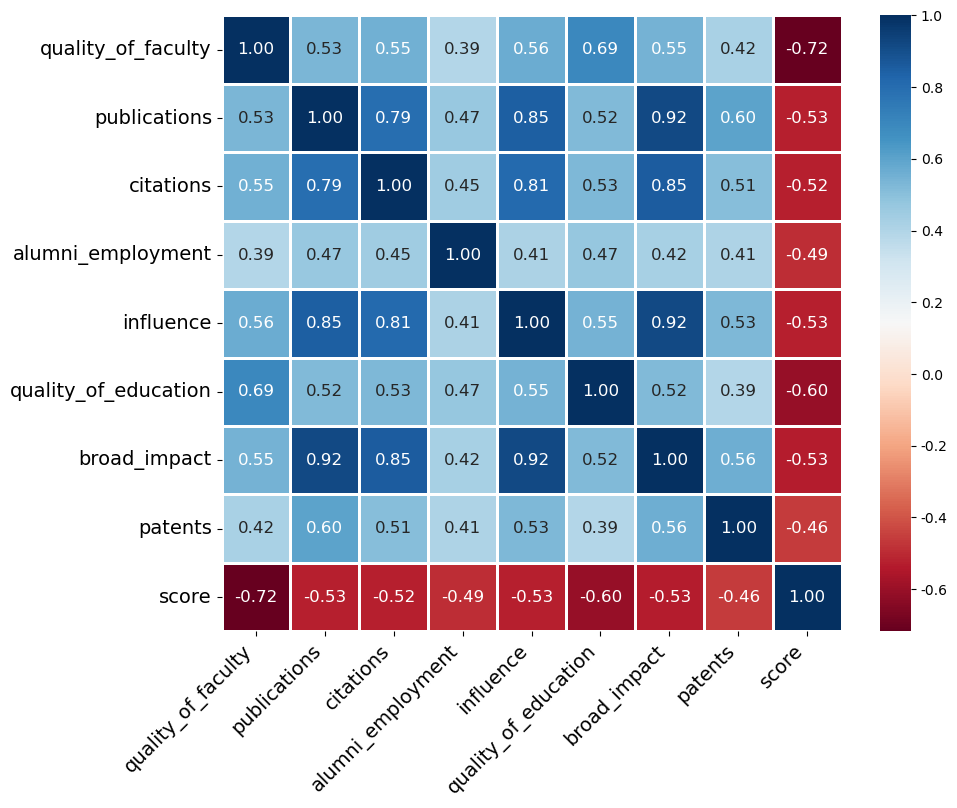

In [32]:
#观察特征相关性和数据的分布情况
plt.subplots(figsize=(10, 8))
plt.rcParams['axes.unicode_minus'] = False
plt.tick_params(labelsize=14)     
heatmap = sns.heatmap(usable_data.corr(), xticklabels=True,
            cmap='RdBu', annot=True, fmt='0.2f',linewidths=2,annot_kws={'size':12})     # 热力图
xticklabels = heatmap.get_xticklabels()                                                 # 获取X轴标签
heatmap.set_xticklabels(xticklabels, rotation=45, ha='right')                           # 通过设置旋转角度和水平对齐方式来调整标签
plt.show()                                                                              # 显示图形

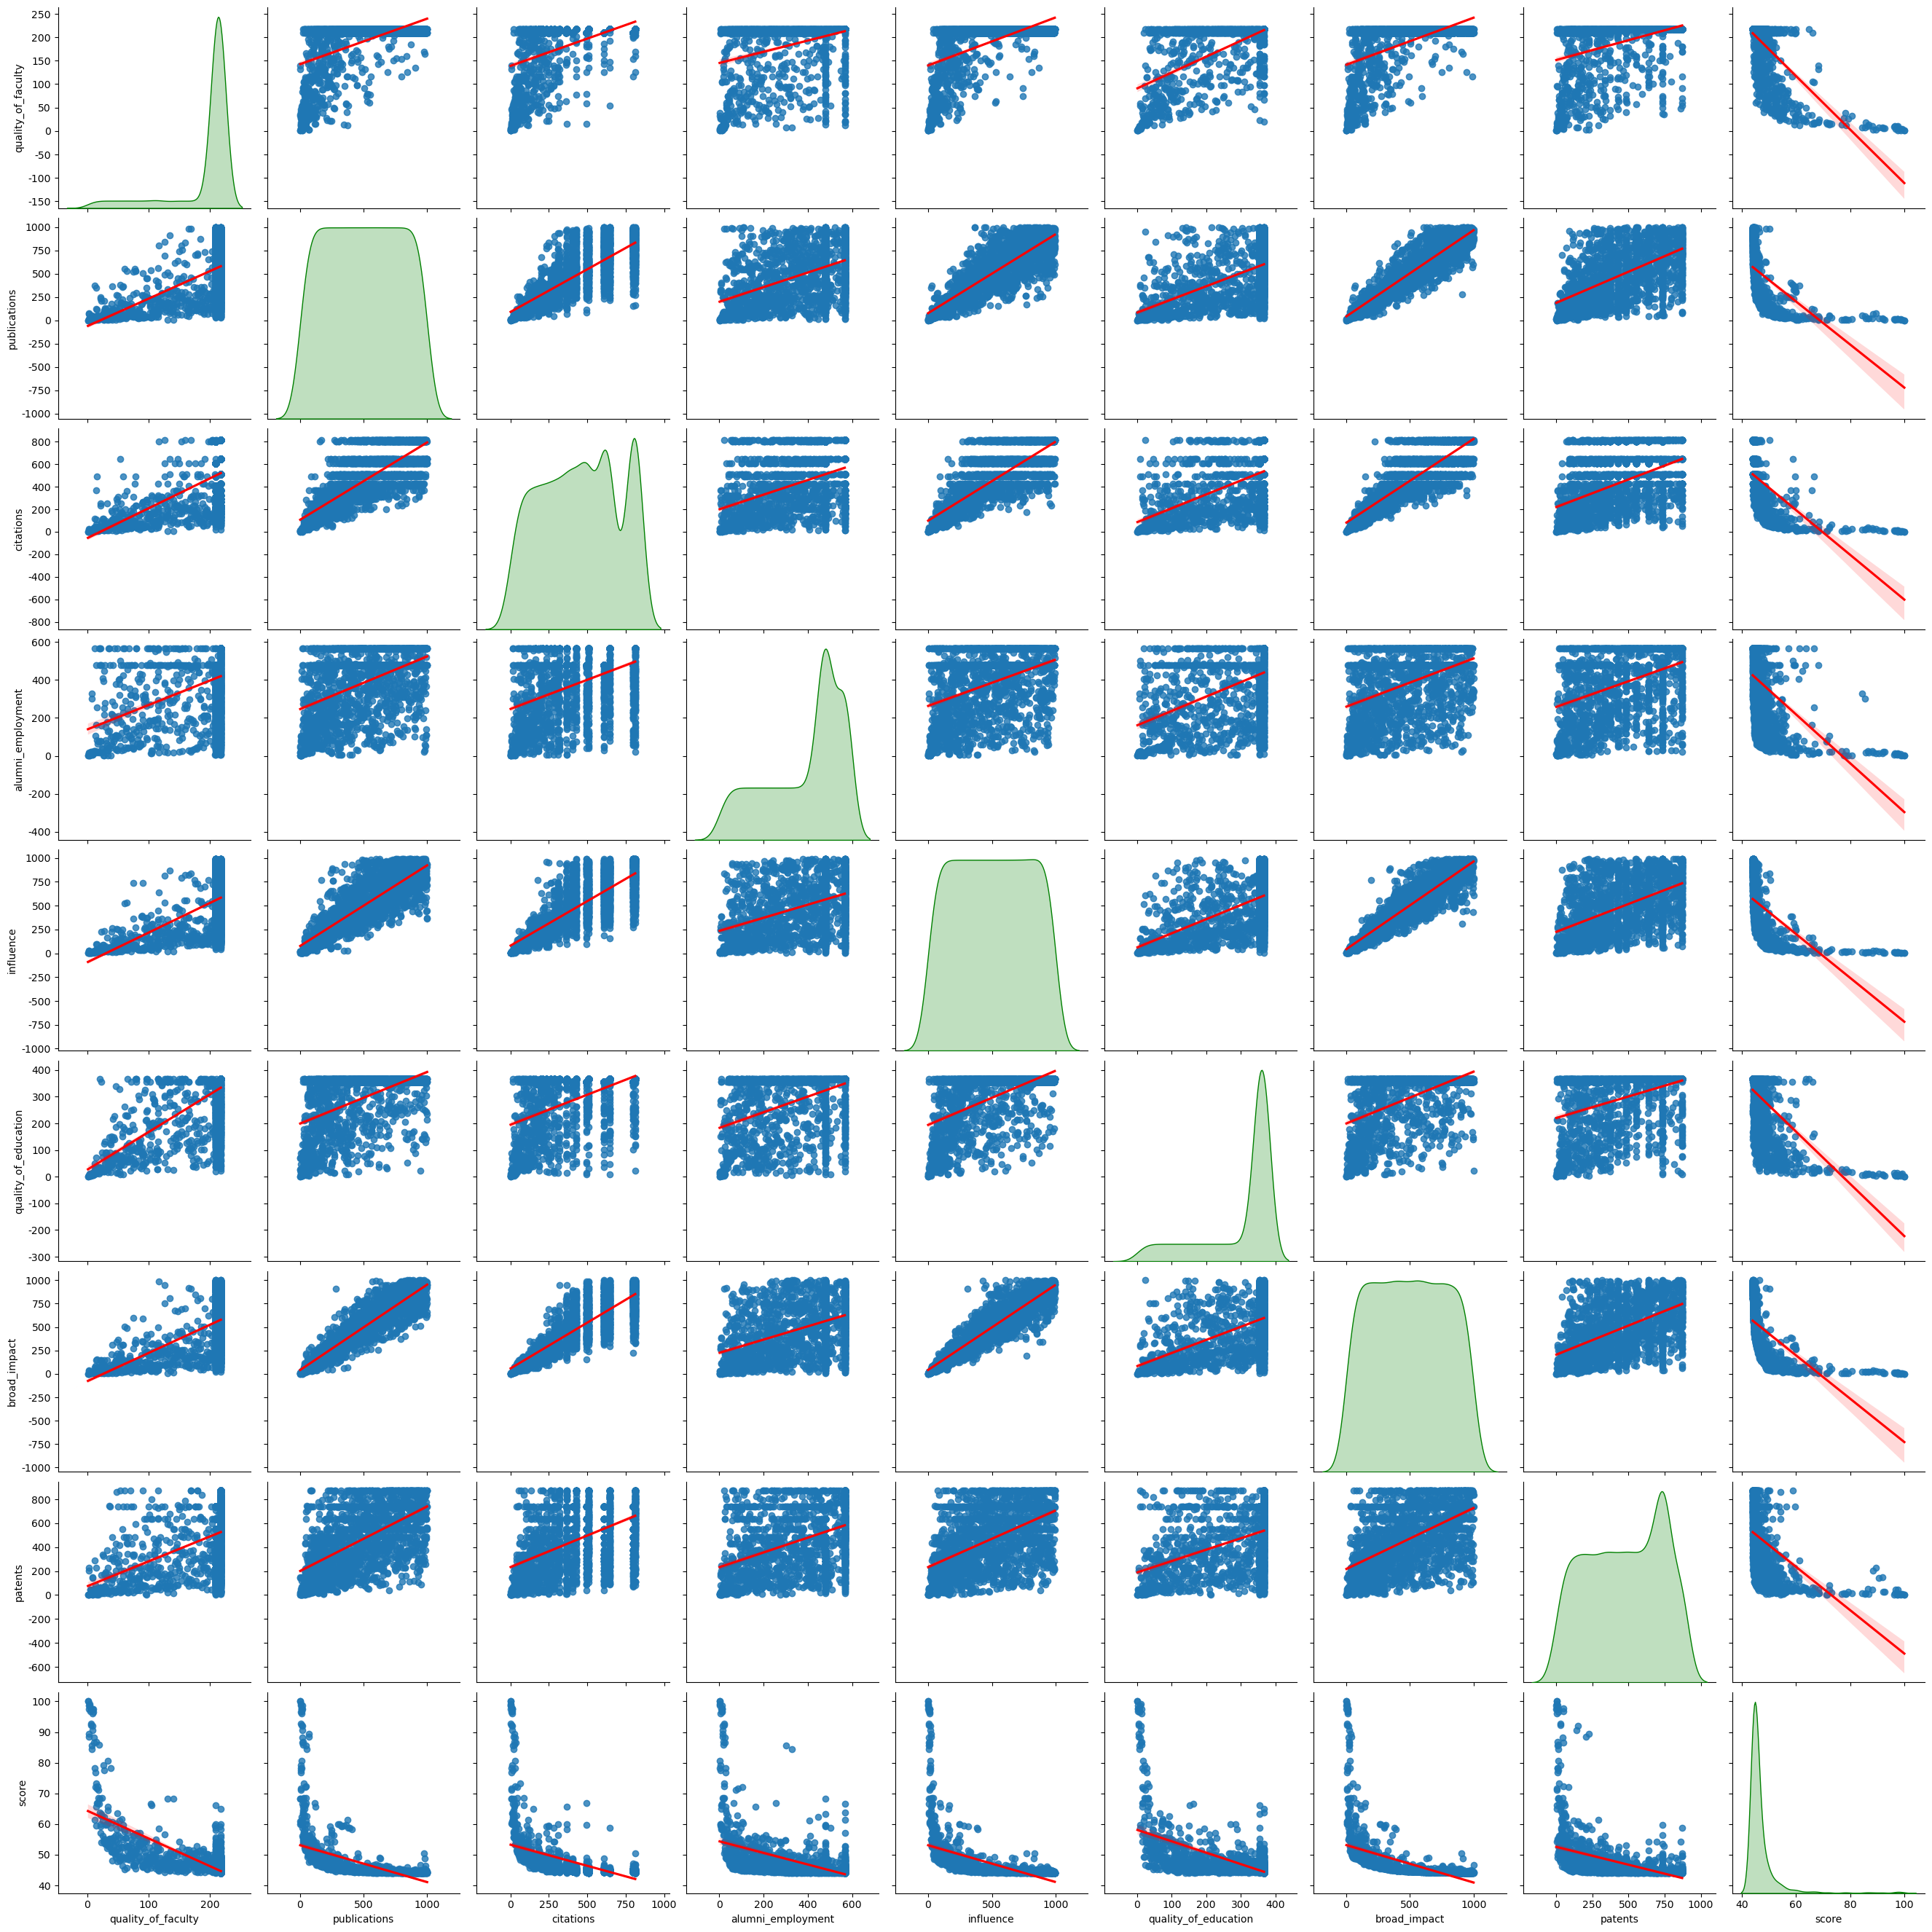

In [33]:
label_kws = {'fontsize': 12, 'labelpad': 10, 'fontweight': 'bold', 'color': 'blue', 'rotation': 45}
grid_kws = {'diag_sharey': False, 'despine': True}
sns.pairplot(usable_data, height=3, kind="reg",diag_kind="kde", diag_kws={'color': 'green'}, plot_kws={'line_kws': {'color': 'red'}}, grid_kws=grid_kws)                              # 数据分布图

In [34]:
# 箱型图处理异常点
def box_outlier(data):
    df_box = data.copy()
    for col in df_box.columns:                                              # 对每一列分别用箱型图进行判断
        if col == 'score': 
            continue
        Q1 = df_box[col].quantile(q=0.25)                                   # 下四分位
        Q3 = df_box[col].quantile(q=0.75)                                   # 上四分位
        low_whisker = Q1 - 3 * (Q3 - Q1)                                    # 下边缘
        up_whisker = Q3 + 3 * (Q3 - Q1)                                     # 上边缘
        
        # 寻找异常点,用上下边缘重置
        rule_low =(df_box[col] < low_whisker)  
        rule_up = (df_box[col] > up_whisker) 
        df_box.loc[rule_low, col] = low_whisker
        df_box.loc[rule_up, col] = up_whisker
    return df_box

df_box = box_outlier(usable_data)
df_box 

,quality_of_faculty,publications,citations,alumni_employment,influence,quality_of_education,broad_impact,patents,score
200,186,1.0,1,1.0,1.0,1.0,1.0,2.0,100.00
201,186,5.0,3,2.0,3.0,11.0,4.0,6.0,99.09
202,186,15.0,2,11.0,2.0,3.0,2.0,1.0,98.69
203,186,10.0,12,10.0,9.0,2.0,13.0,48.0,97.64
204,186,11.0,11,12.0,12.0,7.0,12.0,16.0,97.51
...,...,...,...,...,...,...,...,...,...
2195,218,926.0,812,567.0,845.0,367.0,969.0,816.0,44.03
2196,218,997.0,645,566.0,908.0,236.0,981.0,871.0,44.03
2197,218,830.0,812,549.0,823.0,367.0,975.0,824.0,44.03
2198,218,886.0,812,567.0,974.0,367.0,975.0,651.0,44.02


### 4.4 数据集准备

In [35]:
Y = usable_data['score']
X = usable_data.drop(columns=['score'])
all_y = Y.values
all_x = X.values

# dels = []                                                                                                         # 用3sigma准则清理异常数据，在本实验中不适用。
# for x in range(len(all_x[0])):
#     col_data = all_x[:,x];
#     x_mean = col_data.mean()
#     x_std =col_data.std()
#     for y in range(len(col_data)):
#         if col_data[y]> x_mean + x_std*0.67 or col_data[y] < x_mean - x_std*0.67:                                 #x_std所乘的系数为+-σ的倍率
#             dels.append(y)
# all_x = np.delete(all_x, dels, axis=0)
# all_y = np.delete(all_y, dels, axis=0)
len(all_x),len(all_y)

(2000, 2000)

## 五、模型构建

### 5.1 最小二乘法实现

In [36]:
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)  #将数据分为训练集与测试集
x_train_tensor = torch.tensor(x_train,dtype=torch.float)                                                    #训练集特征numpy转tensor
x_train_tensor = torch.cat((x_train_tensor,  torch.ones([len(x_train),1])),  1)                             #为训练集特征增添偏移量
y_train_tensor = torch.tensor(y_train,dtype=torch.float).view(len(x_train),1)                               #训练集标签numpy转2维tensor

x_test_tensor = torch.tensor(x_test,dtype=torch.float)                                                      #测试集特征numpy转tensor
x_test_tensor = torch.cat((x_test_tensor,   torch.ones([len(x_test),1])),   1)                              #为测试集特征增添偏移量
y_test_tensor = torch.tensor(y_test,dtype=torch.float).view([len(x_test),1])                                #测试集标签numpy转2维tensor

x1x_inverse = torch.inverse(torch.mm(torch.t(x_train_tensor), x_train_tensor))                              #(X'X)^-1                                                                                    
B = torch.mm(torch.mm(x1x_inverse, torch.t(x_train_tensor)), y_train_tensor)                                #β=((X'X)^-1)X'Y
e = y_test_tensor - torch.mm(x_test_tensor,B)                                                               #e=Y-Xβ
loss = torch.mm(torch.t(e),e)                                                                               #loss = e'e
MSE = loss.item()/len(y_train_tensor)
RMSE = MSE**0.5                                                                                             #RMSE= √MSE= √(loss/n)
print('[最小二乘法]RMSE： {:.4f}'.format(RMSE))

var = (torch.tensor(y_test)-torch.mean(torch.tensor(y_test))).view([-1,1])
VAR = torch.mm(torch.t(var),var).item()/len(y_train_tensor)
R2 = 1-MSE/VAR                                                                                              #R^2 = 1-MSE/VAR
print('[最小二乘法]R^2： {:.4f}'.format(R2))

[最小二乘法]RMSE： 1.9620
[最小二乘法]R^2： 0.5669


用梯度下降法实现，数据必须归一化。但在归一化前，可以再进行异常数据的处理。

In [37]:
##数据处理必须选择部分
min_max_scaler = preprocessing.MinMaxScaler()
all_x = min_max_scaler.fit_transform(all_x)                                                                 #数据归一化

### 5.2用梯度下降法实现

梯度下降法的具体实现见下：

In [38]:
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2,random_state=RANDOM_SEED)#将数据分为训练集与测试集

x_train_tensor = torch.tensor(x_train,dtype=torch.float)                                                #训练集特征numpy转tensor
x_train_tensor = torch.cat((x_train_tensor,  torch.ones([len(x_train),1])),  1)                         #为训练集特征增添偏移量
y_train_tensor = torch.tensor(y_train,dtype=torch.float).view(len(x_train),1)                           #训练集标签numpy转2维tensor

x_test_tensor = torch.tensor(x_test,dtype=torch.float)                                                  #测试集特征numpy转tensor
x_test_tensor = torch.cat((x_test_tensor,   torch.ones([len(x_test),1])),   1)                          #为测试集特征增添偏移量
y_test_tensor = torch.tensor(y_test,dtype=torch.float).view([len(x_test),1])                            #测试集标签numpy转2维tensor

b = torch.rand(len(all_x[0])+1,1)                                           
frequency =9000
c = 0.01
for x in range(frequency):
        y_pre = torch.mm(x_train_tensor,b)
        error_b = y_pre - y_train_tensor.view([-1,1])
        f_error_b = torch.mm(torch.t(x_train_tensor),error_b)/len(x_train_tensor)                       #f * error_b
        b = b - c*f_error_b                                                                             #梯归收敛 b=b-α α=c*f*error_b
y_pre = torch.mm(x_test_tensor,b)
loss = torch.tensor(y_test).view([len(x_test),1]) - y_pre
loss = torch.mm(torch.t(loss),loss)

MSE = loss.item()/len(y_pre)
RMSE = MSE**0.5                                                                                         #RMSE= √MSE= √(loss/n)
print('[梯度下降法]RMSE： {:.4f}'.format(RMSE))
var = (torch.tensor(y_test)-torch.mean(torch.tensor(y_test))).view([-1,1])
VAR = torch.mm(torch.t(var),var).item()/len(y_pre)
R2 = 1-MSE/VAR                                                                                          #R^2 = 1-MSE/VAR
print('[梯度下降法]R^2： {:.4f}'.format(R2))

[梯度下降法]RMSE： 3.9379
[梯度下降法]R^2： 0.5639


### 5.3 Sklearn-线性回归

In [39]:
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2,random_state=RANDOM_SEED)   #将数据分为训练集与测试集

reg = LinearRegression()
reg.fit(x_train,y_train)                                                                                    #训练
test_pre=reg.predict(x_test)                                                                                #预测
RMSE = mean_squared_error(y_test,test_pre, squared = False)
print('[sklearn-线性回归]RMSE： {:.4f}'.format(RMSE))
print('[sklearn-线性回归]R^2： {:.4f}'.format(r2_score(y_test,test_pre)))

[sklearn-线性回归]RMSE： 3.9241
[sklearn-线性回归]R^2： 0.5669


<AxesSubplot:>

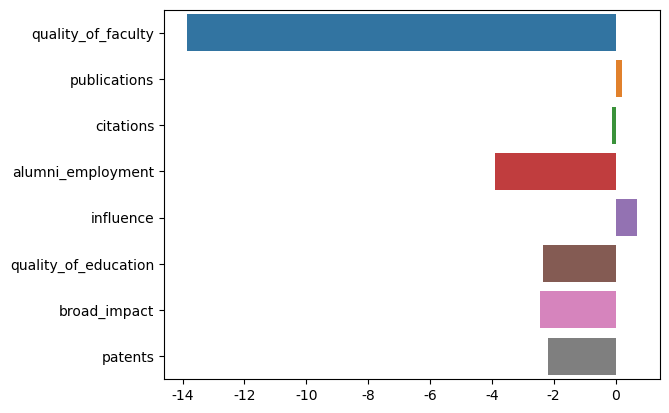

In [40]:
# 模型参数对结果的影响权重
sns.barplot(x =reg.coef_ , y= usable_cols[:-1])



Publications， Influence：共线性的影响

### 5.4 Sklearn-多项式回归

In [41]:
poly_feat = PolynomialFeatures(degree=4)
all_x = poly_feat.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2,random_state=RANDOM_SEED)   #将数据分为训练集与测试集

reg = LinearRegression()
reg.fit(x_train,y_train)                                                                                    #训练
test_pre=reg.predict(x_test)                                                                                #预测
RMSE = mean_squared_error(y_test,test_pre, squared = False)
print('[sklearn-多项式回归]RMSE： {:.4f}'.format(RMSE))
print('[sklearn-多项式回归]R^2： {:.4f}'.format(r2_score(y_test,test_pre)))

[sklearn-多项式回归]RMSE： 1.6833
[sklearn-多项式回归]R^2： 0.9203


## 六、扩展

在前面的数据和特征观察中，有部分的特征如Regin待验证。数据是非数值类型，在线性回归中，为避免数值大小对结果的影响，不能直接数值化。考虑用独执业编码处理； 而broad_impact中有两年的数据缺失。可以进一步补缺，观察其对输出的影响。

### 6.1	数据处理：独热编码region


对特征region进行独热编码。

In [42]:
 # 重新读入 csv 文件为 pandas 的 DataFrame
data_df = pd.read_csv('./data/cwurData.csv') 
data_df = data_df.dropna()  # 舍去包含 NaN 的 row

##重新加入特征region
usable_cols = ['quality_of_faculty', 'publications', 'citations', 'alumni_employment',
                'influence', 'quality_of_education', 'broad_impact', 'patents','region']
X = data_df[usable_cols]
Y = data_df['score']
                             
# 选择需要独热编码的列
data_to_encode = X[['region']]

# 创建 OneHotEncoder 实例
encoder = OneHotEncoder(sparse_output=False, drop='first')  # sparse_output=False 将稀疏矩阵转换为密集矩阵，drop='first' 将生成的第一个编码删除

# 对选择的列进行独热编码
encoded_data = encoder.fit_transform(data_to_encode)

# 将编码后的数据转换为 DataFrame
encoded_df = pd.DataFrame(encoded_data).add_prefix('region_')

# 保持索引一致
X.index = encoded_df.index
# 将独热编码后的数据和原始数据进行合并
X = pd.concat([X, encoded_df], axis=1)

# 删除原始的列
X.drop(['region'], axis=1, inplace=True)

all_y = Y.values
all_x = X.values


#### 6.1.1 最小二乘法

In [43]:
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)  #将数据分为训练集与测试集
x_train_tensor = torch.tensor(x_train,dtype=torch.float)                                                    #训练集特征numpy转tensor
x_train_tensor = torch.cat((x_train_tensor,  torch.ones([len(x_train),1])),  1)                             #为训练集特征增添偏移量
y_train_tensor = torch.tensor(y_train,dtype=torch.float).view(len(x_train),1)                               #训练集标签numpy转2维tensor

x_test_tensor = torch.tensor(x_test,dtype=torch.float)                                                      #测试集特征numpy转tensor
x_test_tensor = torch.cat((x_test_tensor,   torch.ones([len(x_test),1])),   1)                              #为测试集特征增添偏移量
y_test_tensor = torch.tensor(y_test,dtype=torch.float).view([len(x_test),1])                                #测试集标签numpy转2维tensor

x1x_inverse = torch.inverse(torch.mm(torch.t(x_train_tensor), x_train_tensor))                              #(X'X)^-1                                                                                    
B = torch.mm(torch.mm(x1x_inverse, torch.t(x_train_tensor)), y_train_tensor)                                #β=((X'X)^-1)X'Y
e = y_test_tensor - torch.mm(x_test_tensor,B)                                                               #e=Y-Xβ
loss = torch.mm(torch.t(e),e)                                                                               #loss = e'e
MSE = loss.item()/len(y_train_tensor)
RMSE = MSE**0.5                                                                                             #RMSE= √MSE= √(loss/n)
print('[最小二乘法-独热编码]RMSE： {:.4f}'.format(RMSE))

var = (torch.tensor(y_test)-torch.mean(torch.tensor(y_test))).view([-1,1])
VAR = torch.mm(torch.t(var),var).item()/len(y_train_tensor)
R2 = 1-MSE/VAR                                                                                              #R^2 = 1-MSE/VAR
print('[最小二乘法-独热编码]R^2： {:.4f}'.format(R2))

[最小二乘法-独热编码]RMSE： 1.9419
[最小二乘法-独热编码]R^2： 0.5758


#### 6.1.2 梯度下降法

In [44]:
##数据处理必须选择部分
min_max_scaler = preprocessing.MinMaxScaler()
all_x_612 = min_max_scaler.fit_transform(all_x)     

In [45]:
x_train, x_test, y_train, y_test = train_test_split(all_x_612, all_y, test_size=0.2,random_state=RANDOM_SEED)#将数据分为训练集与测试集

x_train_tensor = torch.tensor(x_train,dtype=torch.float)                                                #训练集特征numpy转tensor
x_train_tensor = torch.cat((x_train_tensor,  torch.ones([len(x_train),1])),  1)                         #为训练集特征增添偏移量
y_train_tensor = torch.tensor(y_train,dtype=torch.float).view(len(x_train),1)                           #训练集标签numpy转2维tensor

x_test_tensor = torch.tensor(x_test,dtype=torch.float)                                                  #测试集特征numpy转tensor
x_test_tensor = torch.cat((x_test_tensor,   torch.ones([len(x_test),1])),   1)                          #为测试集特征增添偏移量
y_test_tensor = torch.tensor(y_test,dtype=torch.float).view([len(x_test),1])                            #测试集标签numpy转2维tensor

b = torch.rand(len(all_x_612[0])+1,1)                                           
frequency =90000
c = 0.01
for x in range(frequency):
        y_pre = torch.mm(x_train_tensor,b)
        error_b = y_pre - y_train_tensor.view([-1,1])
        f_error_b = torch.mm(torch.t(x_train_tensor),error_b)/len(x_train_tensor)                       #f * error_b
        b = b - c*f_error_b                                                                             #梯归收敛 b=b-α α=c*f*error_b
y_pre = torch.mm(x_test_tensor,b)
loss = torch.tensor(y_test).view([len(x_test),1]) - y_pre
loss = torch.mm(torch.t(loss),loss)

MSE = loss.item()/len(y_pre)
RMSE = MSE**0.5                                                                                         #RMSE= √MSE= √(loss/n)
print('[梯度下降法-独热编码]RMSE： {:.4f}'.format(RMSE))
var = (torch.tensor(y_test)-torch.mean(torch.tensor(y_test))).view([-1,1])
VAR = torch.mm(torch.t(var),var).item()/len(y_pre)
R2 = 1-MSE/VAR                                                                                          #R^2 = 1-MSE/VAR
print('[梯度下降法-独热编码]R^2： {:.4f}'.format(R2))

[梯度下降法-独热编码]RMSE： 3.8896
[梯度下降法-独热编码]R^2： 0.5745


#### 6.1.3 线性回归

In [46]:
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2,random_state=RANDOM_SEED)   #将数据分为训练集与测试集

reg = LinearRegression()
reg.fit(x_train,y_train)                                                                                    #训练
test_pre=reg.predict(x_test)                                                                                #预测
RMSE = mean_squared_error(y_test,test_pre, squared = False)
print('[线性回归-独热编码]RMSE： {:.4f}'.format(RMSE))
print('[线性回归-独热编码]R^2： {:.4f}'.format(r2_score(y_test,test_pre)))

[线性回归-独热编码]RMSE： 3.8839
[线性回归-独热编码]R^2： 0.5758


### 6.2	数据处理：broad_impact补缺

broad_impact中有2012年和2013年的数据缺失。对其进行补缺以观察对模型的影响。补缺的数，分别用0，broad_impact最大值、最小值、平均值，以及对应学校在2014-2015年的数据进行处理。

In [47]:
data_df = pd.read_csv('./data/cwurData.csv')    # 读入 csv 文件为 pandas 的 DataFrame
# data_df["broad_impact"] = data_df.groupby("institution")["broad_impact"].transform(lambda x: x.fillna(0))
                                                # 补broad_impact为对应大学内的分组平均值
# data_df[data_df.isnull().any(axis=1)]         # 查看空值
data_df=data_df.fillna(0)                       # 分组填充后还是空值的，直接赋为0

In [48]:
usable_cols = ['quality_of_faculty', 'publications', 'citations', 'alumni_employment',
                'influence', 'quality_of_education', 'broad_impact', 'patents']
 # 读入 csv 文件为 pandas 的 DataFrame
X =  data_df[usable_cols]
Y = data_df['score']
all_x = X.values
all_y = Y.values

#### 6.2.1 最小二乘法

使用最小二乘法对加入的数据，重训练：

In [49]:
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)  #将数据分为训练集与测试集
x_train_tensor = torch.tensor(x_train,dtype=torch.float)                                                    #训练集特征numpy转tensor
x_train_tensor = torch.cat((x_train_tensor,  torch.ones([len(x_train),1])),  1)                             #为训练集特征增添偏移量
y_train_tensor = torch.tensor(y_train,dtype=torch.float).view(len(x_train),1)                               #训练集标签numpy转2维tensor

x_test_tensor = torch.tensor(x_test,dtype=torch.float)                                                      #测试集特征numpy转tensor
x_test_tensor = torch.cat((x_test_tensor,   torch.ones([len(x_test),1])),   1)                              #为测试集特征增添偏移量
y_test_tensor = torch.tensor(y_test,dtype=torch.float).view([len(x_test),1])                                #测试集标签numpy转2维tensor

x1x_inverse = torch.inverse(torch.mm(torch.t(x_train_tensor), x_train_tensor))                              #(X'X)^-1                                                                                    
B = torch.mm(torch.mm(x1x_inverse, torch.t(x_train_tensor)), y_train_tensor)                                #β=((X'X)^-1)X'Y
e = y_test_tensor - torch.mm(x_test_tensor,B)                                                               #e=Y-Xβ
loss = torch.mm(torch.t(e),e)                                                                               #loss = e'e
MSE = loss.item()/len(y_train_tensor)
RMSE = MSE**0.5                                                                                             #RMSE= √MSE= √(loss/n)
print('[最小二乘法_补缺]RMSE： {:.4f}'.format(RMSE))

var = (torch.tensor(y_test)-torch.mean(torch.tensor(y_test))).view([-1,1])
VAR = torch.mm(torch.t(var),var).item()/len(y_train_tensor)
R2 = 1-MSE/VAR                                                                                              #R^2 = 1-MSE/VAR
print('[最小二乘法_补缺]R^2： {:.4f}'.format(R2))

[最小二乘法_补缺]RMSE： 2.9976
[最小二乘法_补缺]R^2： 0.5260


#### 6.2.2 梯度下降法

In [50]:
##数据处理必须选择部分
min_max_scaler = preprocessing.MinMaxScaler()
all_x_622 = min_max_scaler.fit_transform(all_x)        

x_train, x_test, y_train, y_test = train_test_split(all_x_622, all_y, test_size=0.2,random_state=RANDOM_SEED)#将数据分为训练集与测试集

x_train_tensor = torch.tensor(x_train,dtype=torch.float)                                                #训练集特征numpy转tensor
x_train_tensor = torch.cat((x_train_tensor,  torch.ones([len(x_train),1])),  1)                         #为训练集特征增添偏移量
y_train_tensor = torch.tensor(y_train,dtype=torch.float).view(len(x_train),1)                           #训练集标签numpy转2维tensor

x_test_tensor = torch.tensor(x_test,dtype=torch.float)                                                  #测试集特征numpy转tensor
x_test_tensor = torch.cat((x_test_tensor,   torch.ones([len(x_test),1])),   1)                          #为测试集特征增添偏移量
y_test_tensor = torch.tensor(y_test,dtype=torch.float).view([len(x_test),1])                            #测试集标签numpy转2维tensor

b = torch.rand(len(all_x_622[0])+1,1)                                           
frequency =90000
c = 0.01
for x in range(frequency):
        y_pre = torch.mm(x_train_tensor,b)
        error_b = y_pre - y_train_tensor.view([-1,1])
        f_error_b = torch.mm(torch.t(x_train_tensor),error_b)/len(x_train_tensor)                       #f * error_b
        b = b - c*f_error_b                                                                             #梯归收敛 b=b-α α=c*f*error_b
y_pre = torch.mm(x_test_tensor,b)
loss = torch.tensor(y_test).view([len(x_test),1]) - y_pre
loss = torch.mm(torch.t(loss),loss)

MSE = loss.item()/len(y_pre)
RMSE = MSE**0.5                                                                                         #RMSE= √MSE= √(loss/n)
print('[梯度下降法-补缺]RMSE： {:.4f}'.format(RMSE))
var = (torch.tensor(y_test)-torch.mean(torch.tensor(y_test))).view([-1,1])
VAR = torch.mm(torch.t(var),var).item()/len(y_pre)
R2 = 1-MSE/VAR                                                                                          #R^2 = 1-MSE/VAR
print('[梯度下降法-补缺]R^2： {:.4f}'.format(R2))

[梯度下降法-补缺]RMSE： 5.9945
[梯度下降法-补缺]R^2： 0.5261


#### 6.2.3 线性回归

In [51]:
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2,random_state=RANDOM_SEED)   #将数据分为训练集与测试集

reg = LinearRegression()
reg.fit(x_train,y_train)                                                                                    #训练
test_pre=reg.predict(x_test)                                                                                #预测
RMSE = mean_squared_error(y_test,test_pre, squared = False)
print('[线性回归-补缺]RMSE： {:.4f}'.format(RMSE))
print('[线性回归-补缺]R^2： {:.4f}'.format(r2_score(y_test,test_pre)))

[线性回归-补缺]RMSE： 5.9953
[线性回归-补缺]R^2： 0.5260


#### 6.2.4 多项式回归

In [52]:
poly_feat = PolynomialFeatures(degree=4)
all_x = poly_feat.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2,random_state=RANDOM_SEED)   #将数据分为训练集与测试集

reg = LinearRegression()
reg.fit(x_train,y_train)                                                                                    #训练
test_pre=reg.predict(x_test)                                                                                #预测
RMSE = mean_squared_error(y_test,test_pre, squared = False)
print('[sklearn-多项式回最-补缺]RMSE： {:.4f}'.format(RMSE))
print('[sklearn-多项式回最-补缺]R^2： {:.4f}'.format(r2_score(y_test,test_pre)))

[sklearn-多项式回最-补缺]RMSE： 2.5986
[sklearn-多项式回最-补缺]R^2： 0.9109


## 七、结果汇总

* 从特征工程和结果上看，本数据集并不适合线性回归。
* 加入地区后，有微小提升，区域偏见还是有体现，但还算相对可信。
* 空数据的补全，本数据中没什么意义。
<div style="text-align:center">

|        方法 | 去除空数据 | 独热编码 | 补缺 |
|----------|----------|----------|----------|
|最小二乘法                   | 1.9620 | 1.9419 | 2.9976|
|梯度下降法                   | 3.9379 | 3.8896 | 5.9945|
|sklearn-线性回归             | 3.9241 | 3.8839 | 5.9953|
|sklearn-多项式回归           | 1.6833 | - | 2.5986|

</div>
